# Lab 4:  Sampling from unknown distributions

Welcome to the 4th Data 102 lab! 

The goal of this Lab is to get you familiar with 3 sampling strategies for obtaining samples from unknown distributions:
 - Rejection Sampling
 - Gibbs Sampling
 - Metropolis Hastings
 
The Lab looks long because we are trying to cover a lot of ground. However there is relatively little code you need to write. The only 'bigish' function you need to write from scratch is **2.a**.


#### The code and responses you need to write are commented out with a message  `TODO: fill in`. There is additional documentation for each part as you go along.

##### Please read carefully the introduction and the instructions to each problem.

## Collaboration Policy
Data science is a collaborative activity. While you may talk with others about the labs, we ask that you **write your solutions individually**. If you do discuss the assignments with others please **include their names** in the cell below.

## Gradescope Submission
To submit this assignment, rerun the notebook from scratch (by selecting Kernel > Restart & Run all), and then print as a pdf (File > download as > pdf) and submit it to Gradescope.


**This assignment should be completed and submitted before Wednesday, Sep 30th, 2020 at 11:59 PM. PST**

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import multivariate_normal, norm, uniform
from ipywidgets import interact, interactive

from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm
  
sns.set(style="dark")
plt.style.use("ggplot")

## Setup

In this Lab you are given a two dimensional unnormalized density function $f(x,y)$ represented by `target_density` below. The goal of the 3 questions in this lab is to build up a sampler that can output samples from the distribution proportional to $f(x,y)$. 

In **Question 1** we will compute samples via *Rejection Sampling*. In part **1.a** we will build a sampler for a 1-dimensional projection of the density. In part **1.b** we will extend the approach to two dimensions.

In **Question 2** we will compute samples via *Gibbs Sampling*. We will use the 1-D rejection sampler as a subroutine.

In **Question 3** we will compute samples via *Metropolis-Hastings*. 

Finally we will compare the above methods.

*Throughout this lab we will assume that our computers have access only to normal and uniform random variables.*

In [2]:
# This is the target unnormalized density from which we would like to sample
# Run this to define the function
# No TODOs here
@np.vectorize # <- decorator, makes function run faster
def target_density(x, y):
    mean1 = [1, 1.7]
    mean2 = [2, 1.3]
    mean3 = [1.5, 1.5]
    mean4 = [2, 2.1]
    mean5 = [1, 1.2]
    cov1=0.2*np.array([[0.2, -0.05], [-0.05, 0.1]])
    cov2 = 0.3*np.array([[0.1, 0.07], [0.07, 0.2]])
    cov3= np.array([[0.1, 0], [0, 0.1]])
    cov4 = 0.1*np.array([[0.3, 0.04], [0.04, 0.2]])
    cov5 = 0.1*np.array([[0.4, -0.04], [-0.04, 0.2]])
    return(multivariate_normal.pdf([x, y], mean=mean1, cov=cov1) + 
           multivariate_normal.pdf([x, y], mean=mean2, cov=cov2) +
           2*multivariate_normal.pdf([x, y], mean=mean3, cov=cov3) +
           0.5*multivariate_normal.pdf([x, y], mean=mean4, cov=cov4)+
           0.5*multivariate_normal.pdf([x, y], mean=mean5, cov=cov5))

#### Let's visualize this density. 

Run the cell below to see a 3D plot of the function along with a contour plot.

In [3]:
# No TODOs here, just run the cell to make plots
# Create a meshgrid of coordinates
coords = np.arange(0.5, 2.5, 0.02)
X, Y = np.meshgrid(coords, coords)

# Compute the value of the target density at all pairs of (x,y) values
Z = target_density(X,Y)


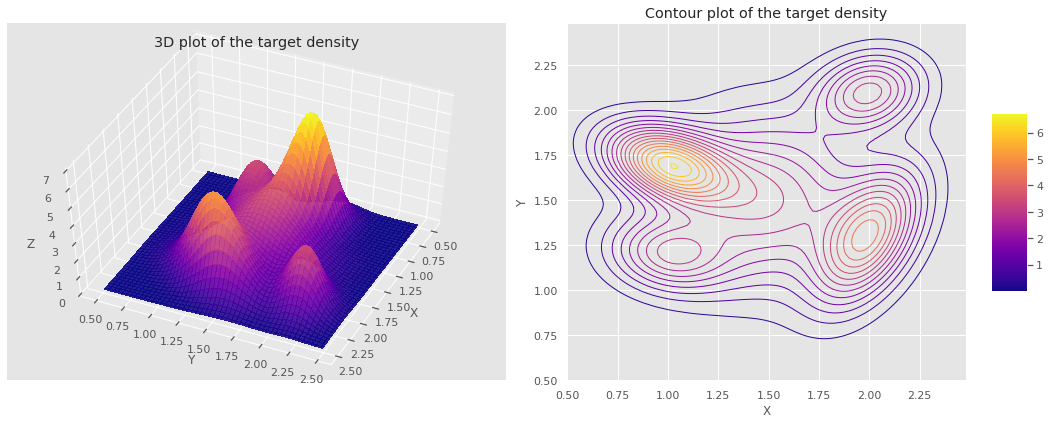

In [4]:
# Display the 3D plot of the target density
fig = plt.figure(figsize=(15,6))

ax0 = fig.add_subplot(121, projection='3d')
ax1 = fig.add_subplot(122)

surf = ax0.plot_surface(X,Y,Z, cmap=cm.plasma, linewidth=0, antialiased=False,alpha = 0.9,)

# Customize the z axis.
ax0.set_zlim(0, 7)
ax0.set_xlabel("X")
ax0.set_ylabel("Y")
ax0.set_zlabel("Z")
ax0.set_title("3D plot of the target density")

# Rotate the axes: you can change these numbers in order to see the distribution from other angles
ax0.view_init(50, 25)

# Plot the contour plot of the density
cont = ax1.contour(X,Y,Z, levels = 20, cmap=cm.plasma, linewidths=1)
ax1.set_xlabel("X")
ax1.set_ylabel("Y")
ax1.set_title("Contour plot of the target density")

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.tight_layout()
plt.show()

Take a moment to examine the plots. Make sure you can see correspondances between each peak in the 3D plot on the left; and the "high-altitude" regions in the countour plot on the right.

Next we will plot 1-dimensional projections of the target densities onto the $X$ and $Y$ axis. These correspond to conditional target distributions of the form $f(x, y=y')$ and $f(x=x', y)$.

In [5]:
# Do not modify
# Run the cell below to define the plotting functions

COORDINATES = np.arange(0, 3, 0.02)
def plot_x_cond(y_val):
    fig, axs = plt.subplots(1, 2)
    fig.set_figheight(5)
    fig.set_figwidth(12)
    axs[0].contour(X,Y,Z, levels = 20, cmap=cm.plasma, alpha = 0.8, linewidths=0.8)
    axs[0].axhline(y_val,  ls="--", color = 'olive', lw = 2)
    axs[0].set_xlabel("X")
    axs[0].set_ylabel("Y")
    axs[0].set_title("Contour plot of the target density")
    
    axs[1].plot(COORDINATES, target_density(COORDINATES, y_val), color = 'olive')
    axs[1].set_ylim(0,10)
    axs[1].set_xlim(0,3)
    axs[1].set_xlabel("X")
    axs[1].set_title("Conditional target density: f(x | y={:.1f})".format(y_val))
    plt.show()
    
def plot_y_cond(x_val):
    fig, axs = plt.subplots(1, 2)
    fig.set_figheight(5)
    fig.set_figwidth(12)
    axs[0].contour(X,Y,Z, levels = 20, cmap=cm.plasma, alpha = 0.8, linewidths=0.8)
    axs[0].axvline(x_val,  ls="--", color = 'olive', lw = 2)
    axs[0].set_xlabel("X")
    axs[0].set_ylabel("Y")
    axs[0].set_title("Contour plot of the target density")
    
    axs[1].plot(COORDINATES, target_density(x_val, COORDINATES), color = 'olive')
    axs[1].set_ylim(0,10)
    axs[1].set_xlim(0,3)
    axs[1].set_xlabel("Y")
    axs[1].set_title("Conditional target density: f(y | x={:.1f})".format(x_val))
    plt.show()

In [6]:
# Display interactive plot
interactive_plot = interactive(plot_x_cond, y_val=(0, 3, 0.1), add_proposal=False)
interactive_plot

interactive(children=(FloatSlider(value=1.0, description='y_val', max=3.0), Output()), _dom_classes=('widget-i…

Set different values of `y_val`, observe the changes in the conditional target density.

In [7]:
# Display interactive plot
interactive_plot = interactive(plot_y_cond, x_val=(0, 3, 0.1), add_proposal=False)
interactive_plot

interactive(children=(FloatSlider(value=1.0, description='x_val', max=3.0), Output()), _dom_classes=('widget-i…

Set different values of `x_val`, observe the changes in the conditional target density.

## Question 1. Rejection Sampling

In this question we will build a rejection sampler. First let's go over the basics of Rejection Sampling. 

Assume we want to sample from an unnormalized target density $f(x)$, using a proposal distribution $Q$, with density $q(x)$. The proposal distribution is chosen such that we have access to samples from it. 

#### Rejection sampling proceeds as follows:

- Find constant $c$, such that $cf(x)\leq q(x)$ on the support
- At each iteration:
    - Sample $x_i \sim Q$
    - Compute the ratio $r = \frac{c(f(x_i))}{q(x_i)} \leq 1$, `accept` the sample with probability `r`, this is equivalent to:
    - Sample $\gamma_i \sim Uniform(0,1)$:
        - `accept` if $\gamma_i \leq r$: Add $x_i$ to the list of samples.
        - `reject` otherwise
        
### 1.a Sample from the unidimensional density $f(x, y=1.2)$
Throughout part 1.a we will consider a Uniform(0,3) as our proposal distribution. Meaning that $q(x) = \frac{1}{3} \ \forall x\in[0,3]$

In [8]:
# Create the target 1D density f(x, y = 1.2)
def target_1D_density(x):
    return(target_density(x, 1.2))

In [9]:
from scipy import stats
# TODO: fill in
# hint the uniform function in scipy might prove useful here
def sample_1D_proposed_distribution(N):
    """ 
    Produces N samples from the Uniform(0,3) proposal distribution
    
    Inputs:
        N : int, desired number of samples
        
    Outputs:
        proposed_samples : ndarray of size N which contains N independent samples from the proposal
    """
    
    proposed_samples = stats.uniform.rvs(loc=0, scale=3, size=N)
    return(proposed_samples)

# TODO: fill in
@np.vectorize
def compute_ratio_1D(proposed_sample, c):
    """
    Computes the ratio between the scaled target density and proposal density evaluated at the 
    proposed sample point
    
    Inputs:
        proposed_sample : float, proposed sample
        c : float, constant scaling factor that ensures that the proposal density is above the target density
        
    Outputs:
        ratio : float
    """
    ratio = (c*target_1D_density(proposed_sample))/stats.uniform.pdf(proposed_sample, loc=0, scale=3)
    assert(ratio <= 1)
    return(ratio)

# TODO: fill in
@np.vectorize
def accept_proposal(ratio):
    """ 
    Accepts or rejects a proposal with probability equal to ratio
    
    Inputs: 
        ratio: float, probability of acceptance
    
    Outputs:
        accept: True/False, if True, accept the proposal
    """
    accept = ratio > stats.uniform.rvs(loc=0, scale=1)
    return(accept)

Now we have all the ingredients for making a sampler:

In [10]:
# TODO: complete the function
def get_1D_samples(N, c): 
    """ 
    Produces samples from target_1D_density
    
    Inputs:
        N : int, number of proposed_samples
        c : float, constant scaling factor that ensures that the proposal density is above the target density
        
    Outputs:
        rejection_samples : ndarray of which contains independent samples from the target
    """
    
    proposed_samples = sample_1D_proposed_distribution(N)
    ratios = compute_ratio_1D(proposed_samples, c)
    #print(ratios)
    accept_array = accept_proposal(ratios)
    #print(accept_array)
    
    rejection_samples = proposed_samples[accept_array]
    return(rejection_samples)

In [11]:
# Validation tests: do not modify
N = 1000
assert(np.abs(1.5-np.mean(get_1D_samples(N, 1/15))) < 0.1)
assert(np.abs(0.3-len(get_1D_samples(N, 1/15))/N) < 0.05)
assert(np.abs(0.23-len(get_1D_samples(N, 1/20))/N) < 0.05)
assert(np.abs(0.18-len(get_1D_samples(N, 1/25))/N) < 0.05)
print('Test passed!')

Test passed!


From the interactive plot above we can see that $f(x, y=1.2)$ is allways smaller than 5. Hence to make it smaller than $q(x) = 1/3$ we need to scale the target density by a factor $c \leq \frac{1}{3}\cdot\frac{1}{5} = 1/15$. 

#### Let's use $c=1/15$, compute target samples and plot their histogram

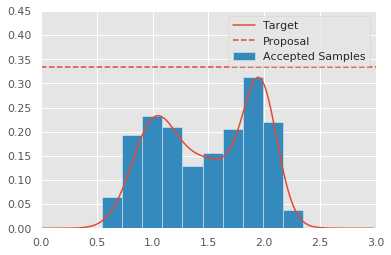

In [12]:
# No TODOs here
# Just run it once you passed the assertion tests above

fig = plt.figure(figsize = (6, 4))
c = 1/15
target_samples = get_1D_samples(1000, c)
density_values =  target_1D_density(COORDINATES)*c
plt.plot(COORDINATES, density_values, label='Target')
plt.axhline(1/3, ls = '--', label = 'Proposal')
n, bins, rects = plt.hist(target_samples, density = True, label="Accepted Samples")
max_height = np.max([r.get_height() for r in rects])
for r in rects:
    r.set_height(r.get_height()*np.max(density_values)/max_height)
plt.legend()
plt.xlim(0,3)
plt.ylim(0,0.45)
plt.show()

#### Computing the acceptance ratio for varying scaling constants c

In [13]:
# No TODOs here
# Just run it and comment in the section below

N = 1000
c_values = [0.06, 0.05, 0.04, 0.03, 0.02, 0.01]
for c in c_values:
    # compute target samples
    target_samples = get_1D_samples(N, c)
    acceptance_percentage = 100*len(target_samples)/N
    print("For c = {:.2f}, the acceptance percentage is {:.1f}%".format(c, acceptance_percentage))

For c = 0.06, the acceptance percentage is 26.9%
For c = 0.05, the acceptance percentage is 21.9%
For c = 0.04, the acceptance percentage is 16.2%
For c = 0.03, the acceptance percentage is 14.3%
For c = 0.02, the acceptance percentage is 8.9%
For c = 0.01, the acceptance percentage is 3.7%


#### `TODO`: in the cell below explain why the accepted percentage decreases as $c$ decreases:

As c decreases, the ratio between the scaled target density and proposal density evaluated at the proposed sample point also decreases. This makes the threshold at which we would accept a proposal smaller, making it harder to accept a proposal and thus we see fewer acceptances.

### 1.b Sample from the two-dimensional density $f(x, y)$

In two dimensions Rejection Sampling is nearly identical to the 1-dimension case:

- Find constant $c$, such that $cf(x, y)\leq q(x, y)$ on the support
- At each iteration:
    - Sample $(x_i, y_i) \sim Q$
    - Compute the ratio $r = \frac{c(f(x_i, y_i))}{q(x_i, y_i)} \leq 1$, `accept` the sample with probability `r`, this is equivalent to:
    - Sample $\gamma_i \sim Uniform(0,1)$:
        - `accept` if $\gamma_i \leq r$, add $(x_i, y_i)$ to the list of samples.
        - `reject` otherwise

Throughout part 1.b we will consider $(x, y)\sim Uniform(0,3)\times Uniform(0,3)$ as our proposal distribution. Meaning that $q(x, y) = \frac{1}{9}\ \forall x, y\in[0,3]$

`TODO` complete the function below

In [14]:
# TODO: fill in
@np.vectorize
def compute_ratio_2D(proposed_sample_x, proposed_sample_y, c):
    """
    Computes the ratio between the scaled target density and proposal density evaluated at the 
    proposed sample point
    
    Inputs:
        proposed_sample_x : float, x components of the proposed sample point
        proposed_sample_y : float, y components of the proposed sample point
        c : float, constant scaling factor that ensures that the proposal density is above the target density
        
    Outputs:
        ratio : float
    """
    ratio = (c*target_density(proposed_sample_x, proposed_sample_y))/(stats.uniform.pdf(proposed_sample_x, loc=0, scale=3)*stats.uniform.pdf(proposed_sample_x, loc=0, scale=3))
    assert(ratio <= 1)
    return(ratio)

Now we have all the ingredients for making a sampler. 

In [15]:
# No TODOs here, just run the 2D version of the functions we built in 1.a
def get_2D_samples(N, c): 
    """ 
    Produces samples from target_density
    
    Inputs:
        N : int, number of proposed_samples
        c : float, constant scaling factor that ensures that the proposal density is above the target density
        
    Outputs:
        rejection_samples : ndarray of which contains independent samples from the target
    """
    proposed_samples_x = sample_1D_proposed_distribution(N)
    proposed_samples_y = sample_1D_proposed_distribution(N)
    ratios = compute_ratio_2D(proposed_samples_x, proposed_samples_y, c)
    accept_array = accept_proposal(ratios)
    proposed_samples = np.concatenate((proposed_samples_x.reshape(N,1), proposed_samples_y.reshape(N,1)), axis = 1)
    rejection_samples = proposed_samples[accept_array]
    return(rejection_samples)

In [16]:
# Validation tests: Do not modify
N = 5000
assert(np.abs(0.075-len(get_2D_samples(N, 0.015))/N) < 0.015)
assert(np.abs(0.045-len(get_2D_samples(N, 0.01))/N) < 0.015)
print('Test passed!')

Test passed!


From the contour plot above we can see that $f(x, y)$ is allways smaller than 7.4. Hence to make it smaller than $q(x) = 1/9$ we need to scale the target density by a factor $c \leq \frac{1}{7.4}\cdot\frac{1}{9} = 0.015$. 

#### Let's use $c=0.015$, compute target samples and plot them on top the contour lines

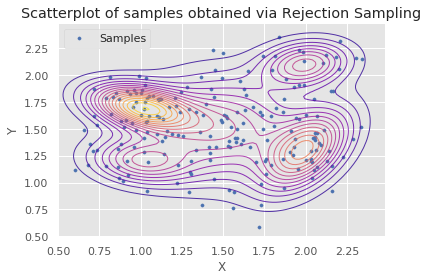

In [17]:
fig = plt.figure(figsize=(6,4))

# Plot the contour plot of the density
cont = plt.contour(X,Y,Z, levels = 20, cmap=cm.plasma, linewidths=1, alpha = 0.8)
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Scatterplot of samples obtained via Rejection Sampling")

# Add sample points obtained via rejection sampling
c = 1/72
target_samples = get_2D_samples(3000, c)
plt.scatter(target_samples[:,0], target_samples[:,1], c='b', alpha = 1, s = 10, label = 'Samples')

plt.legend()
plt.tight_layout()
plt.show()

In [18]:
# No need to modify this
# just run it and comment in the section below

N = 3000
c_values = [0.015, 0.01, 0.005, 0.001]
for c in c_values:
    # compute target samples
    target_samples = get_2D_samples(N, c)
    acceptance_percentage = 100*len(target_samples)/N
    print("For c = {:.3f}, the acceptance percentage is {:.1f}%".format(c, acceptance_percentage))

For c = 0.015, the acceptance percentage is 7.4%
For c = 0.010, the acceptance percentage is 4.9%
For c = 0.005, the acceptance percentage is 2.5%
For c = 0.001, the acceptance percentage is 0.6%


#### `TODO`: in the cell below explain why the acceptance percentage is lower for 2d rejection sampling:

The distribution of the proposal density is farther away from the ceiling of the target density in 2d than it is in 1d, thus we see fewer acceptances because the ratio between the scaled target density and proposal density will be smaller, making it harder to make acceptances.

## Question 2. Gibbs Sampling

In this question we will build a Gibbs sampler. First let's go over the basics of Gibbs Sampling.

Assume we want to sample from an unnormalized target density $f(x, y)$. 

#### Gibbs Sampling proceeds as follows:

- Start at an initial point $(x_0, y_0)$
- For `i` in `number of iterations`:
    - Condition on $y=y_{i-1}$: Sample $x_i \sim f(x| y=y_{i-1})$ 
        - Add $(x_i, y_{i-1})$ to the list of samples
    - Condition on $x=x_{i}$: : Sample $y_i \sim f(y| x=x_{i})$ 
        - Add $(x_i, y_{i})$ to the list of samples
    
In many problems we can sample the univariate distributions directly. In this case we don't know how to sample them directly, but we can use the 1-D rejection sampler that we computed in 1.a.

In the cell below we wrote for you helper functions that sample from the conditionals aboves. They are essentially the same function you wrote in 1.a, just slightly modified such that we perform rejection sampling until we get one valid sample.

In [19]:
# No TODOs here:
# Just look at these helper functions and make sure you understand the syntax

def sample_x_cond(fixed_y_val):
    """ 
    Produces one sample from x_i ~ f(x | y=fixed_y_val)
    
    Inputs:
        fixed_y_val : float, current value of y, on which we condition
    
    Outputs:
        x_sample: float, one sample from x_i ~ f(x, y=fixed_y_val)
        num_samples : int, number of tries until we accepted a sample
        
    """
    def conditional_density(x):
        return(target_density(x, fixed_y_val))
    x_sample = None
    num_samples = 0
    c = 0.33/(0.2+max(conditional_density(np.arange(0.5, 2.5, 0.05)))) # <- we are cheating a bit here by 
                                                                       # looking for a tight c value
    while x_sample is None:
        proposed_sample = sample_1D_proposed_distribution(1)
        num_samples += 1
        ratio = conditional_density(proposed_sample)*3*c
        assert(ratio <= 1)
        accept = accept_proposal(ratio)
        if accept:
            x_sample = proposed_sample[0]
    return(x_sample, num_samples)


def sample_y_cond(fixed_x_val):
    """ 
    Produces one sample from y_i ~ f(y | x=fixed_x_val)
    
    Inputs:
        fixed_x_val : float, current value of y, on which we condition
    
    Outputs:
        y_sample: float, one sample from y_i ~ f(y | x=fixed_x_val)
        num_samples : int, number of tries until we accepted a sample
        
    """
    def conditional_density(y):
        return(target_density(fixed_x_val, y))
    y_sample = None
    num_samples = 0
    c = 0.33/(0.2+max(conditional_density(np.arange(0.5, 2.5, 0.05))))
    while y_sample is None:
        proposed_sample = sample_1D_proposed_distribution(1)
        num_samples += 1
        ratio = conditional_density(proposed_sample)*3*c
        assert(ratio <= 1)
        accept = accept_proposal(ratio)
        if accept:
            y_sample = proposed_sample[0]
    return(y_sample, num_samples)


### 2.a `TODO`: Build a Gibbs sampler using the helper functions above
`Note`: Don't forget that at each iteration the Gibbs sampler adds two samples to the list of samples: $(x_i, y_{i-1})$ and $(x_i, y_{i})$

In [20]:
# TODO: fill in
def get_2D_Gibbs_samples(N, x_0, y_0):
    """
    Produces N samples from the target density using Gibbs Sampling
    
    Inputs: 
        N : desired number of samples
        x_0, y_0 : floats, the coordinates of the starting point
        
    Outputs:
        gibbs_samples : array of dimension (N, 2) where each row is a sample from the target distribution
                        of the form (x_i, y_i)
        num_samples : total number of samples required (total number of tries until we accepted N samples)
    """
    gibbs_samples = []
    num_samples = 0
    x_1 = sample_x_cond(y_0)
    gibbs_samples.append((x_1[0], y_0))
    y_1 = sample_y_cond(x_1[0])
    gibbs_samples.append((x_1[0], y_1[0]))
    num_samples += x_1[1]
    num_samples += y_1[1]
    for i in range(int((N-2)/2)):
        x_i = sample_x_cond(y_1[0])
        gibbs_samples.append((x_i[0], y_1[0]))
        y_1 = sample_y_cond(x_i[0])
        gibbs_samples.append((x_i[0], y_1[0]))
        num_samples += x_i[1]
        num_samples += y_1[1]
    #print(gibbs_samples)
    #print(num_samples)
        
    
    return(gibbs_samples, num_samples)

In [21]:
# Validation tests: Do not modify
N = 100
output = get_2D_Gibbs_samples(N, 1, 1)
assert(len(output) == 2)
assert(len(output[0]) == N)
assert(len(output[0][0]) == 2)
assert(np.abs(410-output[1]) < 150)
print('Test passed!')

Test passed!


### 2.b : Path traced by the Gibbs sampler
Run the code below to overlay the path traced by the Gibbs Sampler

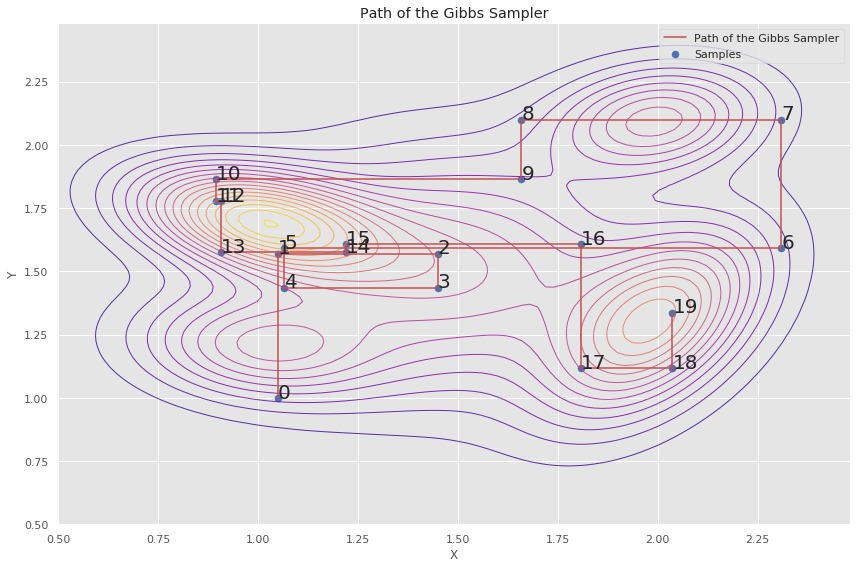

In [34]:
# No TODOs here
# Just run this once you've passed the validation tests above
N = 20
target_samples, total_samples = get_2D_Gibbs_samples(N, 1, 1)
target_samples = np.array(target_samples)

fig = plt.figure(figsize=(12,8))

# Plot the contour plot of the density
cont = plt.contour(X,Y,Z, levels = 20, cmap=cm.plasma, linewidths=1, alpha = 0.8)
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Path of the Gibbs Sampler")

# Add sample points obtained via Gibbs sampling
plt.scatter(target_samples[:,0], target_samples[:,1], c='b', alpha = 1, s=50, label = 'Samples')
for i in range(N):
    plt.annotate(i, (target_samples[i,0], target_samples[i,1]), fontsize = 20)
plt.plot(target_samples[:,0], target_samples[:,1], c='r', alpha = 1, label = 'Path of the Gibbs Sampler')

plt.legend()
plt.tight_layout()
plt.show()

#### `TODO`: Inspect the scatter plot above. Trace the Gibbs sampler path from the initial point (labeled 0) to the final point. What do you observe? Why do you think that's the case.

I've noticed that each point is nearby or concentrated around the high-density contour regions. I also noticed that the path is fairly boxy (from one point to the next is a straight line and it only moves horizonatally/vertically) and that's because we are changing one variable while the other one stays fixed.

### 2.c: 'Efficiency' of Gibbs Sampling

In [28]:
# Let's compute 1000 Gibbs samples and compute how many times the rejection sampling subroutine 
# accepted the proposed sample (running this might take a little while)
N = 1000
target_samples, total_samples = get_2D_Gibbs_samples(N, 1, 1)
acceptance_rate = N/total_samples*100
print("The acceptance rate for Gibbs Sampling is {:.1f}%".format(acceptance_rate))

The acceptance rate for Gibbs Sampling is 23.4%


#### `TODO`: How does Gibbs Sampling compare to vanilla Rejection Sampling from 2b? Is this approach more efficient or less efficient? Why do you think that's the case?

Gibbs sampling generates an acceptance rate that is much higher than that of vanilla rejection sampling. Because of such Gibbs sampling is more efficient and I think that's because we're sampling from a 1-d conditional density and do not have to worry about the issues encountered in higher dimensions from problem 1b.

## Question 3. Metropolis Hastings

In this final question we will build a Metropolis-Hastings sampler. First let's go over the basics of Metropolis-Hastings Sampling. 

Assume we want to sample from an unnormalized target density $f(x, y)$. 

#### In this question we will consider a Random-Walk Metropolis Hasting Algorithm. The algorithm proceeds as follows:

- Start at an initial point $(x_0, y_0)$
- For `i` in `number of iterations`:
    - Condition on $(x,y)=(x_{i-1},y_{i-1})$. Define proposal distribution $Q(x, y| x_{i-1},y_{i-1}):\ \ \begin{bmatrix} x\\ y\end{bmatrix}\sim Normal\left(\begin{bmatrix} x_{i-1}\\ y_{i-1}\end{bmatrix}, \sigma^2 I\right)$
    - Sample $(x',y') \sim Q(x, y| x_{i-1},y_{i-1})$ 
    - Compute the ratio $r = \frac{f(x', y')}{f(x_{i-1},y_{i-1})} \frac{q(x_{i-1},y_{i-1}|x', y')}{q(x', y'|x_{i-1},y_{i-1})} =  \frac{f(x', y')}{f(x_{i-1},y_{i-1})}$,
    - If $r \geq  1$: `move` : $(x_i, y_i) = (x', y')$ _(we move to the proposed location)_
    - If $r \leq  1$: `move` with probability $r$, `stay` with probability $1-r$, this is equivalent to:
        - Sample $\gamma_i \sim Uniform(0,1)$:
        - if $\gamma_i \leq r$, `move` : $(x_i, y_i) = (x', y')$
        - otherwise `stay`: $(x_i, y_i) = (x_{i-1}, y_{i-1})$
    - Add $(x_i, y_i)$ to the list of samples
    
    
`Note`: in step 3, when computing the ratio $r$ we can cancel out the $q$ terms. We can do that because the proposal distribution is symmetric, meaning that ${q(x_{i-1},y_{i-1}|x', y')}={q(x', y'|x_{i-1},y_{i-1})}$

In [29]:
# No TODOs here: we are providing all the functions to you
# Spend some time examining the code and the algorithm described above

def sample_proposed_normal_distribution(mean, sigma_squared):
    """ 
    Produces a sample from the Uniform(0,3) proposal distribution
    
    Inputs:
        mean : array of length 2, containing the mean of the proposal distributions
        sigma_squared : float, the variance of the proposal distribution
        
    Outputs:
        proposed_sample : array of size 2 which contains a sample (x, y) from the proposal
    """
    
    proposed_sample = multivariate_normal.rvs(mean = mean, cov = sigma_squared)
    return(proposed_sample)

def compute_ratio(proposed_sample, current_sample):
    """
    Computes the ratio r:
    
    Inputs: 
        proposed_sample : array of size 2 which contains sample (x, y) from the proposal
        current_sample : array of size 2 which contains the current (x, y) sample
        
    Outputs:
        ratio : float
    """
    ratio = target_density(*proposed_sample)/target_density(*current_sample)
    return(ratio)
    
def move_now(ratio):
    """ 
    Decides to move to the proposed location, or stay at the current location
    
    Inputs: 
        ratio: float
    
    Outputs:
        move: True/False, if True, move to the proposed locatio,
                          if False, stay at the current location
    """
    if ratio >= 1:
        move = True
        return(move)
    else:
        gamma = uniform.rvs(0, 1)
        move = gamma <= ratio
        return(move)

In [30]:
# No TODOs here: Just run the cell to define the function

def get_2D_MH_samples(N, x_0, y_0, sigma_squared):
    """
    Produces N sampled from the target density using Gibbs Sampling
    
    Inputs: 
        N : desired number of samples
        x_0, y_0 : floats, the coordinates of the starting point
        sigma_squared : float, the variance of the proposal distribution
        
    Outputs:
        MH_samples : array of dimension (N, 2) where each row is a sample from the target distribution
                        of the form (x_i, y_i)
        num_moves : number of times the MH algorithm moved to a new point
    """
    MH_samples = []
    current_sample = [x_0, y_0]
    num_moves = 0
    for i in range(N):
        proposed_sample = sample_proposed_normal_distribution(current_sample, sigma_squared)
        ratio = compute_ratio(proposed_sample, current_sample)
        if move_now(ratio):
            current_sample = proposed_sample
            num_moves += 1
        MH_samples.append(current_sample)
    return(MH_samples, num_moves)

#### Run the code below to compute Metropolis Hastings samples for proposal distribution with different variance levels. We overlay the samples on top of the usual contour plots.

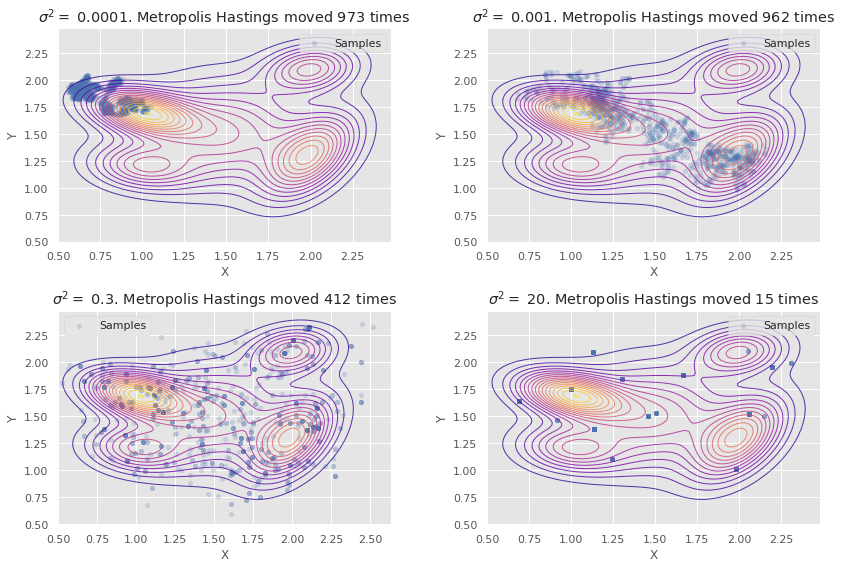

In [31]:
# No TODOs here: Just run the code to create the plots
# Spend some time investigating the code
N = 1000
sigma_squared_values = [0.0001, 0.001, 0.3, 20]
initial_point = [1, 1.75]

fig, axs = plt.subplots(2, 2)
fig.set_figheight(8)
fig.set_figwidth(12)

itr = 0
for i in range(2):
    for j in range(2):
        sigma_squared = sigma_squared_values[itr]
        target_samples, num_moves = get_2D_MH_samples(N, *initial_point, sigma_squared)
        # Convert to numpy array
        target_samples = np.array(target_samples)

        # Plot the contour plot of the density
        cont = axs[i,j].contour(X,Y,Z, levels = 20, cmap=cm.plasma, linewidths=1, alpha = 0.8)
        # Add sample points obtained via MH sampling
        axs[i,j].scatter(target_samples[:,0], target_samples[:,1], c='b', alpha = 0.2, s=20, label = 'Samples')
        
        axs[i,j].set_xlabel("X")
        axs[i,j].set_ylabel("Y")
        axs[i,j].set_title("$\\sigma^2 = $ {}. Metropolis Hastings moved {} times".format(sigma_squared, num_moves))
        axs[i,j].legend()
        itr += 1
plt.tight_layout()
plt.show()

#### `TODO`: Examine the 4 plots above. Each plot contains 1000 Metropolis-Hastongs samples, by considering proposal distributions with different variances. What do you observe? 

- Why do samples stay clustered close to each-other for small value of $\sigma^2$?
- Why does the MH algorithm have so much fewer moves when the value of $\sigma^2$ is largest?
- Which value of $\sigma^2$ would you choose out of the above and why?

- For small values of sigma squared, the acceptance rate will be high, but successive samples will move around the space slowly. The algorithm proposes small jumps and almost all will be accepted, but the size of the jumps will be too small for the algorithm to explore the whole space and thus will take a long time to converge to its stationary distribution.
- When sigma squared is largest, the acceptance rate will be very low and almost all steps under the MH algorithm will be rejected. The algorithm will propose large jumps to regions where the target distribution density is small. Thus it will reject most proposed moves and will stay in the same spot for many iterations.
- I would choose a $\sigma^2$ of 0.3 because it seems like the sample points converged to the target distribution density and explored the whole space the best out of the four options.

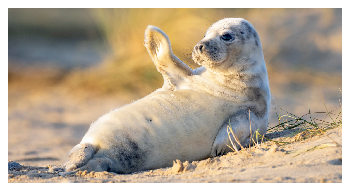

Congrats! You made it to the end of the lab!!!


In [32]:
import matplotlib.image as mpimg
img = mpimg.imread('baby_seal.png')
imgplot = plt.imshow(img)
imgplot.axes.get_xaxis().set_visible(False)
imgplot.axes.get_yaxis().set_visible(False)
plt.show()
print('Congrats! You made it to the end of the lab!!!')